In [1]:
import keras  
import tensorflow as tf
from keras.applications.vgg16 import VGG16  
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input  
import numpy as np


"Construnt extracted feature model by pre-trained VGG16"
height, width = 512, 512
ext_model = VGG16(weights='imagenet', include_top=False)
Raw_path = "deep_512.h5"
Model_path = "deep_inverse_512.h5"
"Extract feature patch from block3_conv1 output "
for i in range(11):
    ext_model.layers.pop()
ext_model.outputs = [ext_model.layers[-1].output]
ext_model.layers[-1].outbound_nodes = []
"Don't train extraction model"
for layer in ext_model.layers:
    layer.trainable = False

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
"Generator for training data"
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
real_path = "/data1/home/feynman52/supvict123/pic/real/"
style_path = "/data1/home/feynman52/supvict123/pic/style/"
real_generator = datagen.flow_from_directory(real_path, target_size=(height, width), class_mode=None, shuffle=True, batch_size=10)
style_generator = datagen.flow_from_directory(style_path, target_size=(height, width), class_mode=None, shuffle=True, batch_size=10)

Found 23817 images belonging to 1 classes.
Found 40504 images belonging to 1 classes.


In [5]:
import os
import time
import h5py
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

"extracted feature by ImageDataGenerator"
def Generate_Extraction(path, size = 1, real_generator = real_generator, style_generator = style_generator):
    if os.path.isfile(path):
        print("file existed!")
    else:
        "batch_size :how many times to generte, nb_validation_samples : how many data it output each time"
        "total data : batch_size*nb_validation_samples"
        nb_validation_samples = 10
        end_time, start_time = 0, 0
        "Generate a file for recording extraction"
        with h5py.File(path, 'w') as hf:
            features = ext_model.predict_generator(real_generator, nb_validation_samples)  
            hf.create_dataset("X_train", data=features, maxshape=(None, height//4, width//4, 256))
        "Adding more and more data for real image and style image"
        for i in range(size):
            with h5py.File(path, 'a') as hf:     
                hf["X_train"].resize((hf["X_train"].shape[0] + 100), axis = 0)
                hf["X_train"][-100:] = ext_model.predict_generator(real_generator, nb_validation_samples)
                "Check data size and time cost"
                if i % 10== 0:
                    end_time = time.time()
                    print("data size:{}, time cost :{}".format(hf["X_train"].shape, end_time - start_time))
                    start_time = time.time()
        for i in range(size):
            with h5py.File(path, 'a') as hf:     
                hf["X_train"].resize((hf["X_train"].shape[0] + 100), axis = 0)
                hf["X_train"][-100:] = ext_model.predict_generator(style_generator, nb_validation_samples)
                if i % 10== 0:
                    end_time = time.time()
                    print("data size:{}, time cost :{}".format(hf["X_train"].shape, end_time - start_time))
                    start_time = time.time()
                    
Generate_Extraction(path =Raw_path, size = 10, real_generator = real_generator, style_generator = style_generator)

data size:(200, 128, 128, 256), time cost :1544965533.2603366
data size:(1200, 128, 128, 256), time cost :117.2845892906189


In [6]:
from keras import backend

"Compute variation loss for final output"
def total_variation_loss(y_true,y_pred):
    height = 512
    width =512

    a = backend.square(y_pred[:, :height - 1, :width - 1, :] - y_pred[:, 1: , :width - 1, :])
    b = backend.square(y_pred[:, :height-1, :width - 1, :] - y_pred[:, :height - 1, 1:, :])
    return backend.mean(backend.pow(a + b, 1))

"Compute abstract concept loss for block3_conv1"
def content_loss(y_true,y_pred):
    return backend.mean(backend.square(y_pred - y_true))

def deprocess_output(bgr):
    import tensorflow as tf
    height = 512
    width =512
    VGG_MEAN = [103.939, 116.779,  123.68]
    b, g, r = tf.split(bgr, num_or_size_splits = 3, axis=3, num=None,name='split')
    r += VGG_MEAN[0]
    g += VGG_MEAN[1]
    b += VGG_MEAN[2]
    rgb = tf.concat(axis = 3,values = [r, g, b])
    return rgb

In [7]:
from keras.models import Sequential
from keras import initializers
from keras.layers import Input, Conv2DTranspose, Lambda, Dropout, ReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D

"Construct an inverse network for extraction freature to image"
inverse_model = Sequential([
    
    Conv2DTranspose(128, (3, 3), padding='same', strides=1, kernel_initializer = "glorot_normal"),
    BatchNormalization(axis = 1),
    BatchNormalization(axis = 2),
    ReLU(),
    UpSampling2D(size=(2, 2), data_format="channels_last"),
    Conv2DTranspose(128, (3, 3), strides=1, padding='same', kernel_initializer = "glorot_normal"),
    BatchNormalization(axis = 1),
    BatchNormalization(axis = 2),
    ReLU(),
    Conv2DTranspose(64, (3, 3), strides=1 , padding='same', kernel_initializer = "glorot_normal"),
    BatchNormalization(axis = 1),
    BatchNormalization(axis = 2),
    ReLU(),
    UpSampling2D(size=(2, 2), data_format="channels_last"),
    Conv2DTranspose(64, (3, 3), strides=1 , padding='same', kernel_initializer = "glorot_normal"),
    BatchNormalization(axis = 1),
    BatchNormalization(axis = 2),
    ReLU(),
    Conv2DTranspose(3, (3, 3), strides=1 , padding='same', kernel_initializer = "glorot_normal"),
    Lambda(deprocess_output)])


In [8]:
from random import randint, choice
import random
sys_random = random.SystemRandom()
"Generator for fit_generator"
def generate_batch_data_random(x, y, batch_size, path):
    while (True):
        try:
            i = sorted(np.random.randint(0,5200, size = (batch_size))+np.random.randint(5201,10200, size = (batch_size)))
            with h5py.File(path, 'a') as hf:
                X_train = hf["X_train"][i]
            yield ([X_train,X_train],[X_train,X_train])
        except:
            pass

In [10]:
import keras.backend as K
from keras.models import Model
from keras.callbacks import Callback

class DisplayLearningRate(Callback):
    '''Display Learning rate .
    '''
    def __init__(self):
        super(DisplayLearningRate, self).__init__()

    def on_epoch_begin(self, epoch, logs={}):
        assert hasattr(self.model.optimizer, 'lr'), \
            'Optimizer must have a "lr" attribute.'
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        self.model.optimizer.lr = self.model.optimizer.lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        lr_now = K.get_value(self.model.optimizer.lr)
        print('Epoch %05d: Learning rate is  %s' % (epoch, lr_now))
        

In [11]:
from keras.models import Model, load_model
"Set to training loss for variation and content"


if os.path.isfile(Model_path):
    inverse_model = load_model(Model_path)
else:
    pass
"content loss"
input1 = Input(shape=(height//4, width//4, 256))
code1 = inverse_model(input1)
code1 = Lambda(preprocess_input)(code1)
end1 = ext_model(code1)
"variation loss"
input2 = Input(shape=(height//4, width//4, 256))
end2 = inverse_model(input2)
"training process"
opt = keras.optimizers.adam(lr=0.001, decay=0.00001)
model = Model(inputs=[input1,input2], outputs=[end1, end2])
model.compile(optimizer=opt, loss=[content_loss, total_variation_loss], metrics=None, loss_weights = [1,0.0001])
model.fit_generator(generate_batch_data_random([],[],4, path = Raw_path),
                    callbacks = [DisplayLearningRate()],steps_per_epoch=5,epochs=10, workers=4)

#inverse_model.save(filepath)

/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/10
Epoch 00000: Learning rate is  0.001
5/5 [==============================] - 55s 11s/step - loss: 19924.2826 - vgg16_loss: 19924.2182 - sequential_2_loss: 644.9197
Epoch 2/10
Epoch 00001: Learning rate is  0.0009999002
5/5 [==============================] - 36s 7s/step - loss: 17748.0262 - vgg16_loss: 17747.9686 - sequential_2_loss: 579.2846
Epoch 3/10
Epoch 00002: Learning rate is  0.0009997
5/5 [==============================] - 35s 7s/step - loss: 15796.6217 - vgg16_loss: 15796.5588 - sequential_2_loss: 627.0505
Epoch 4/10
Epoch 00003: Learning rate is  0.0009994004
5/5 [==============================] - 35s 7s/step - loss: 11824.2145 - vgg16_loss: 11824.1736 - sequential_2_loss: 410.5548
Epoch 5/10
Epoch 00004: Learning rate is  0.0009990004
5/5 [==============================] - 32s 6s/step - loss: 17515.4990 - vgg16_loss: 17515.4412 - sequential_2_loss: 577.3284
Epoch 6/10
Epoch 00005: Learning rate is  0.0009985014
5/5 [==============================] - 35s 7s/step - l

Exception ignored in: <generator object generate_batch_data_random at 0x7f8a00035e08>
RuntimeError: generator ignored GeneratorExit


In [14]:
inverse_model.save(Model_path)

/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


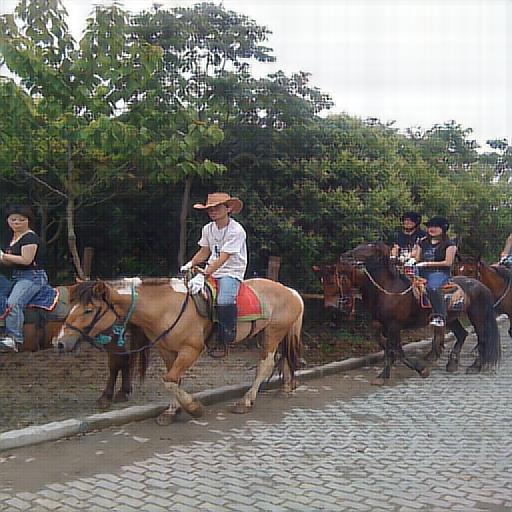

In [13]:
import h5py
from PIL import Image
from keras.models import Model, load_model
"Test for inverse network"
inverse_model = load_model(Model_path)
with h5py.File(Raw_path, 'r') as hf:
    y = 7431
    x = inverse_model.predict(hf["X_train"][y:y+1])
Image.fromarray(np.clip(x[0], 0, 255).astype('uint8'))

In [17]:
"Swap feature patch "

def style_swap(content, style, filter_size = 3):
    height, width =content.shape[1], content.shape[2]
    "split extracted feature in filter size for row"
    rows = tf.split(style, num_or_size_splits=list(
            [filter_size] * (height // filter_size) + [width % filter_size]), axis=1)[:-1]
    "split every row in filter size for colum"
    cells = [tf.split(row, num_or_size_splits=list(
            [filter_size] * (height // filter_size) + [width % filter_size]), axis=2)[:-1]
            for row in rows]
    "collect all patch"
    stacked_cells = [tf.stack(row_cell, axis=4) for row_cell in cells]
    filters = tf.concat(stacked_cells, axis=-1)
    swaped_list = []
    for style_filter in tf.unstack(filters, axis=0, num=1):
        swaped_list.append(swap(content, style_filter, filter_size))
    
    return tf.concat(swaped_list, axis=0)

def swap(content_feature, style_feature, filter_size = 3):
    height, width  = tf.shape(content_feature)[1], tf.shape(content_feature)[2]
    normalized_filters = tf.nn.l2_normalize(style_feature, dim=(0, 1, 2))

    strides=[1,1,1,1]
    "find the most similar patch for tow images and swap them"
    similarity = tf.nn.conv2d(content_feature, normalized_filters, strides=strides, padding="VALID")
    arg_max_filter = tf.argmax(similarity, axis=-1)
    one_hot_filter = tf.one_hot(arg_max_filter, depth=similarity.get_shape()[-1].value)
    swap = tf.nn.conv2d_transpose(one_hot_filter, style_feature, output_shape=tf.shape(content_feature),
                                    strides=strides, padding="VALID")

    return swap //(filter_size**2)

/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
dim is deprecated, use axis instead
(1, 126, 126, 1764)


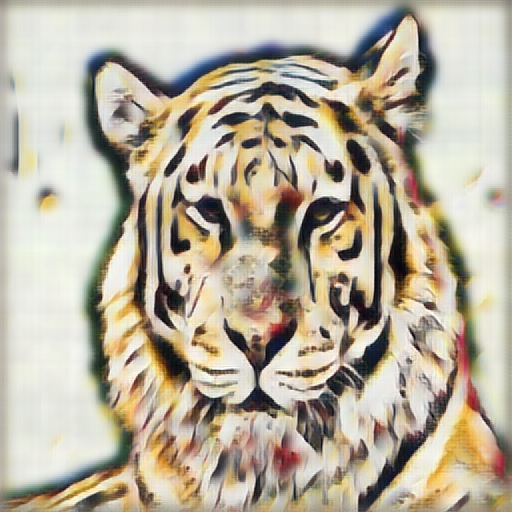

In [15]:
import h5py
from keras.models import Model, load_model
from PIL import Image

"Test for inverse network"
inverse_model = load_model(Model_path)

style_path = '/data1/home/feynman52/supvict123/1045295.jpg'
style = Image.open(style_path)
style = style.resize((height, width))
style = np.asarray(style, dtype='int16')
style = np.expand_dims(style, axis=0)
style = preprocess_input(style)
style = ext_model.predict(style)


real_path = '/data1/home/feynman52/supvict123/290px-Siberischer_tiger_de_edit02.jpg'
real = Image.open(real_path)
real = real.resize((height, width))
real = np.asarray(real, dtype='int16')
real = np.expand_dims(real, axis=0)
real = preprocess_input(real)
real = ext_model.predict(real)

with tf.Session() as sess:
    result = sess.run(style_swap(real,style, 3))
test = inverse_model.predict(result)
Image.fromarray(np.clip(test[0], 0, 255).astype('uint8'))

/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(1, 126, 126, 1764)


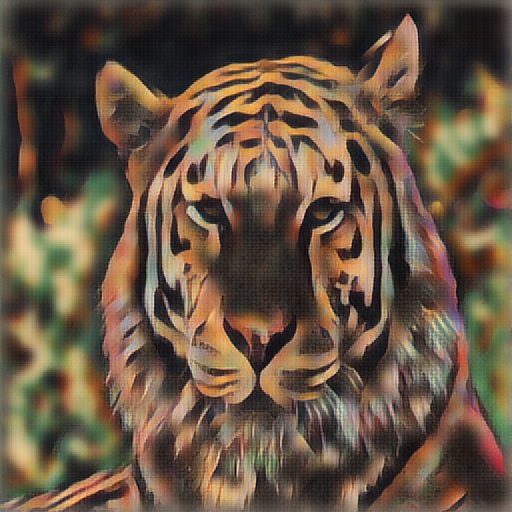

In [16]:
import h5py
from keras.models import Model, load_model
from PIL import Image

"Test for inverse network"
inverse_model = load_model(Model_path)

style_path = '/data1/home/feynman52/supvict123/Vassily_Kandinsky,_1939_-_Composition_10.jpg'
style = Image.open(style_path)
style = style.resize((height, width))
style = np.asarray(style, dtype='int16')
style = np.expand_dims(style, axis=0)
style = preprocess_input(style)
style = ext_model.predict(style)


real_path = '/data1/home/feynman52/supvict123/290px-Siberischer_tiger_de_edit02.jpg'
real = Image.open(real_path)
real = real.resize((height, width))
real = np.asarray(real, dtype='int16')
real = np.expand_dims(real, axis=0)
real = preprocess_input(real)
real = ext_model.predict(real)

with tf.Session() as sess:
    result = sess.run(style_swap(real,style, 3))
test = inverse_model.predict(result)
Image.fromarray(np.clip(test[0], 0, 255).astype('uint8'))